In [12]:
from qiskit import *
import numpy as np
from qiskit.visualization import plot_histogram
import qiskit.tools.jupyter 
import matplotlib.pyplot as plt

In [13]:
sim = Aer.get_backend('qasm_simulator')
shots = 20000

In [14]:
## Create 7mod15 gate
N = 15
m = int(np.ceil(np.log2(N)))

U_qc = QuantumCircuit(m)
U_qc.x(range(m))
U_qc.swap(1, 2)
U_qc.swap(2, 3)
U_qc.swap(0, 3)

U = U_qc.to_gate()
U.name ='{}Mod{}'.format(7, N)

In [15]:
def cU_multi(k):
    circ = QuantumCircuit(m)
    for _ in range(2**k):
        circ.append(U, range(m))
    
    U_multi = circ.to_gate()
    U_multi.name = '7Mod15_[2^{}]'.format(k)
    
    cU_multi = U_multi.control()
    return cU_multi

In [16]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

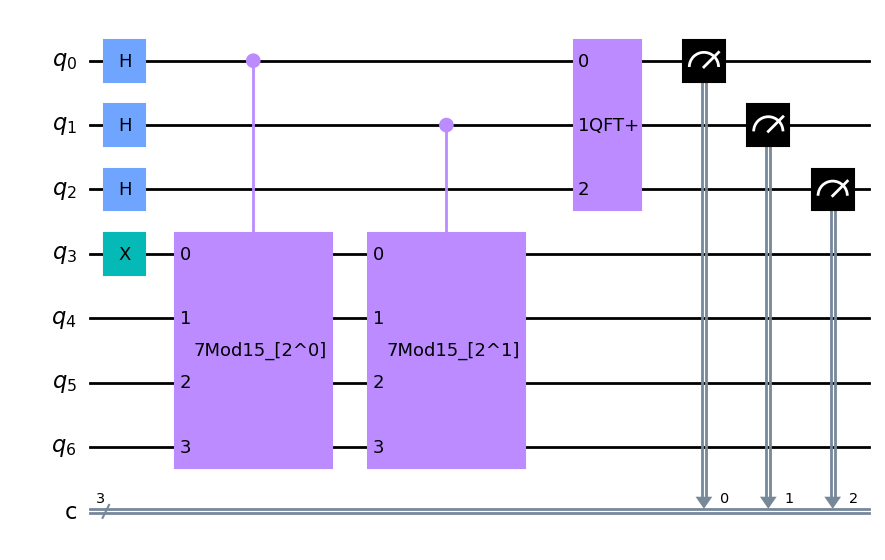

In [17]:
# QPE circuit for Shor
t = 3 
shor_QPE = QuantumCircuit(t+m, t)
shor_QPE.h(range(t))

shor_QPE.x(t)
for idx in range(t-1):
    shor_QPE.append(cU_multi(idx), [idx]+ list(range(t,t+m)))

qft_dag = qft(t).inverse()
qft_dag.name = 'QFT+'

shor_QPE.append(qft_dag, range(t))
shor_QPE.measure(range(t), range(t))

shor_QPE.draw()

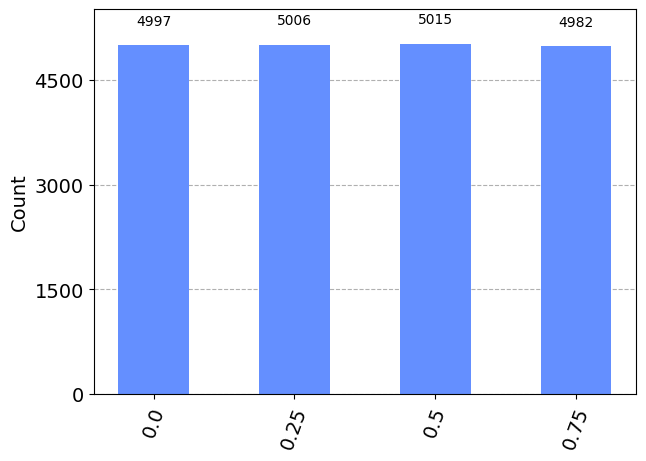

In [18]:
count_QPE = execute(shor_QPE, sim, shots=shots).result().get_counts()
key_new = [str(int(key,2)/2**3) for key in count_QPE.keys()]
count_new_QPE = dict(zip(key_new, count_QPE.values()))
plot_histogram(count_new_QPE)

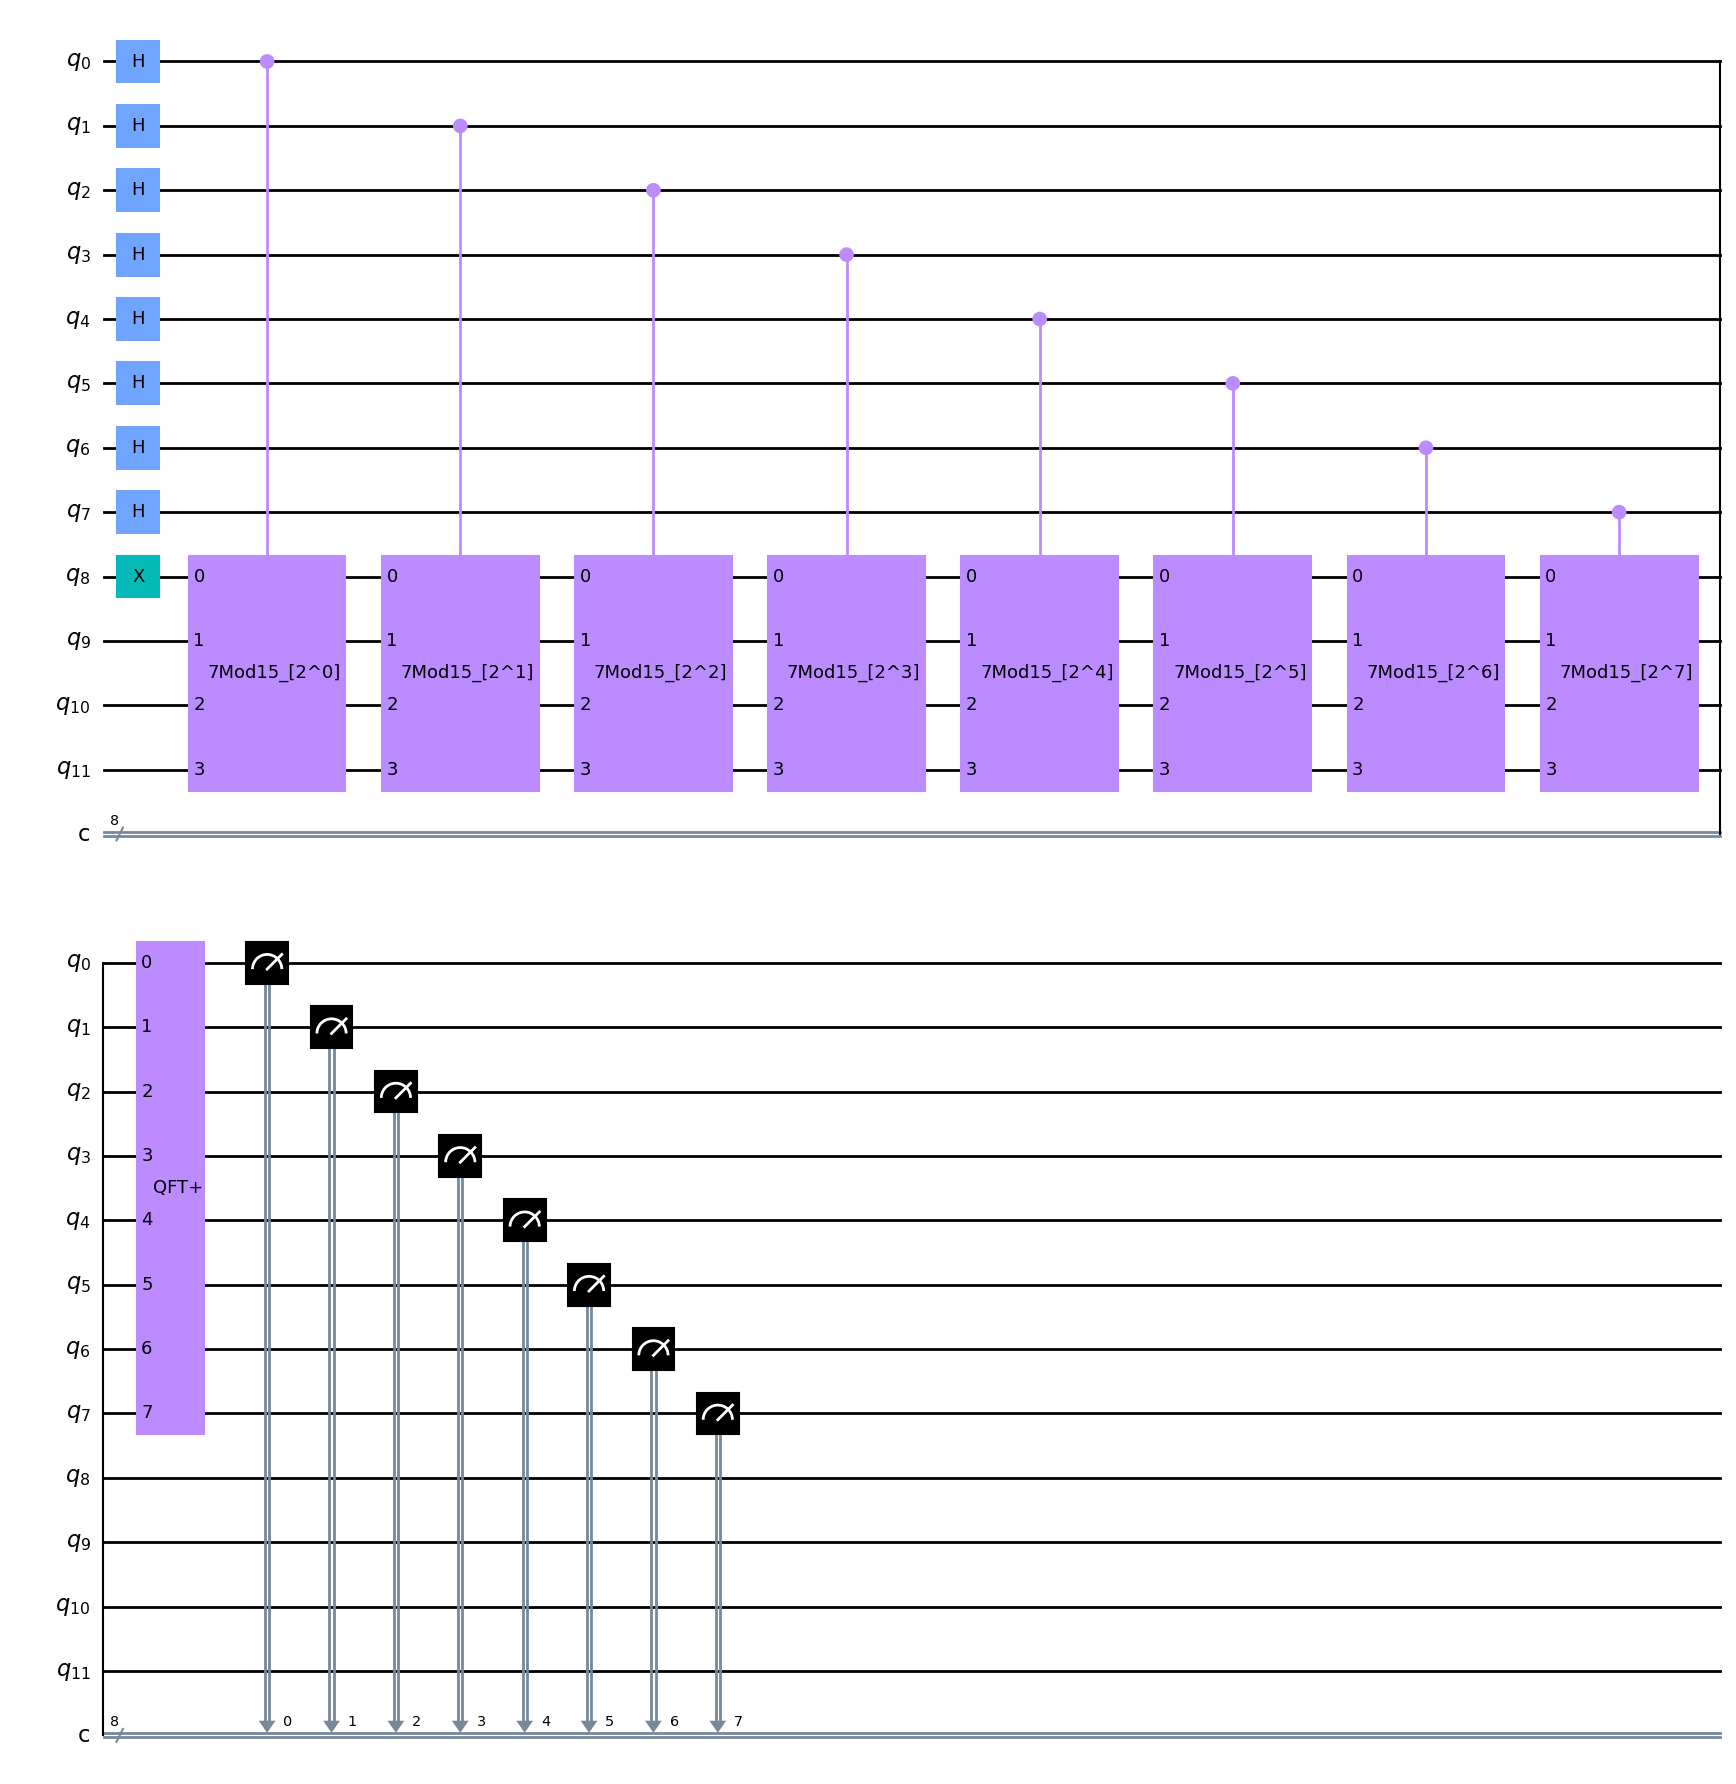

In [19]:
t = 2*m

shor_Orig = QuantumCircuit(t+m, t)
shor_Orig.h(range(t))

shor_Orig.x(t)
for idx in range(t):
    shor_Orig.append(cU_multi(idx), [idx]+ list(range(t,t+m)))

qft_dag = qft(t).inverse()
qft_dag.name = 'QFT+'

shor_Orig.append(qft_dag, range(t))
shor_Orig.measure(range(t), range(t))
    
shor_Orig.draw()

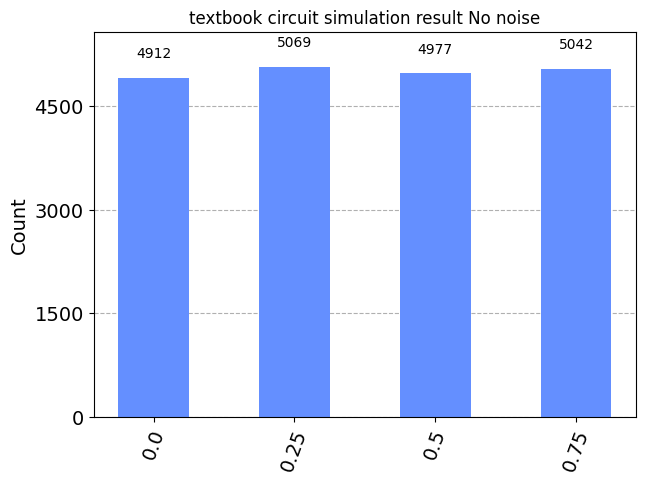

In [20]:
count_Orig = execute(shor_Orig, sim, shots=shots).result().get_counts()
key_new = [str(int(key,2)/2**t) for key in count_Orig.keys()]
count_new_Orig = dict(zip(key_new, count_Orig.values()))
plot_histogram(count_new_Orig, title='textbook circuit simulation result No noise')

In [21]:
from qiskit.providers.fake_provider import FakeMelbourne
backend = FakeMelbourne()
shots=8192

In [22]:
shorOrig_trans = transpile(shor_Orig, backend, optimization_level=3)
count_shorOrig_noise = execute(shor_Orig, backend, shots=shots).result().get_counts()

In [23]:
key_new = [str(np.round(int(key,2)/2**t,3)) for key in count_shorOrig_noise.keys()]
count_new_Orig_noise = dict(zip(key_new, count_shorOrig_noise.values()))

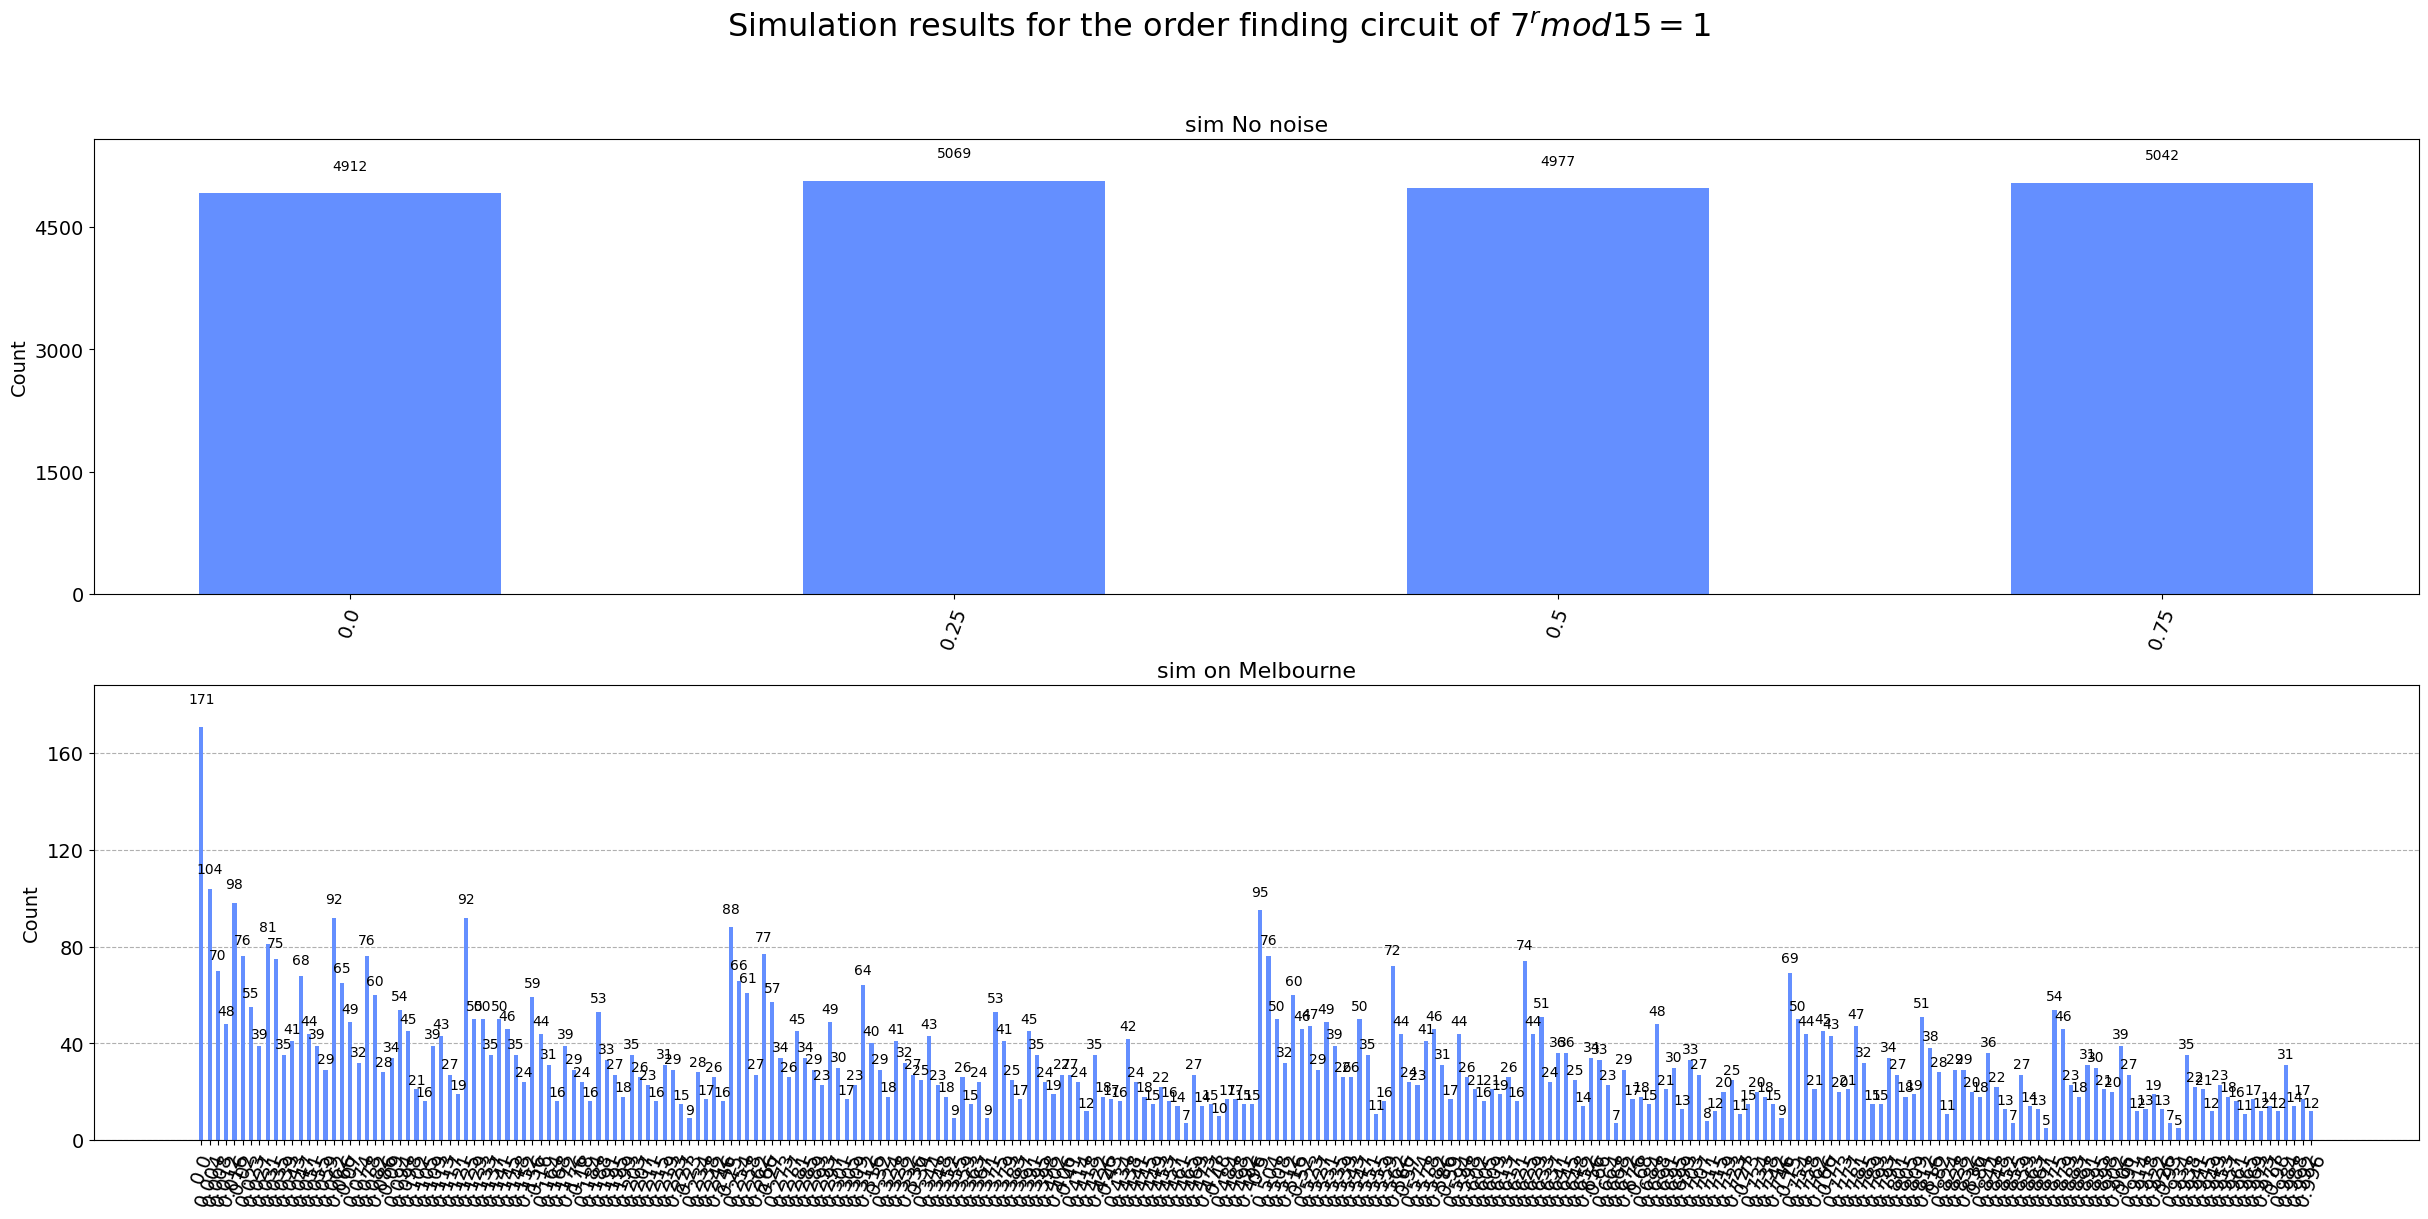

In [24]:
fig, ax = plt.subplots(2,1, figsize=(30,13))
fig.suptitle('Simulation results for the order finding circuit of $7^{r} mod 15 = 1$', fontsize=23)
plot_histogram(count_new_Orig, ax=ax[0])
plot_histogram(count_new_Orig_noise, ax=ax[1])
ax[0].set_title('sim No noise', fontsize=16)
ax[1].set_title('sim on Melbourne', fontsize=16)
plt.show()